# Statsbomb - Spanish LaLiga - Andreas Christou

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import glob
import json
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from IPython.display import display

First, we want to determine the competition (La Liga) id from the competition.json file. So, we open the file, and we can see some records below, showing all the seasons in all the competitions containing in the file.

In [2]:
competitions = pd.read_json("./data/competitions.json")
competitions.tail()

,competition_id,season_id,country_name,competition_name,competition_gender,season_name,match_updated,match_available
33,11,38,Spain,La Liga,male,2005/2006,2020-07-29T05:00,2020-07-29T05:00
34,11,37,Spain,La Liga,male,2004/2005,2020-07-29T05:00,2020-07-29T05:00
35,49,3,United States of America,NWSL,female,2018,2020-07-29T05:00,2020-07-29T05:00
36,2,44,England,Premier League,male,2003/2004,2020-08-31T20:40:28.969635,2020-08-31T20:40:28.969635
37,72,30,International,Women's World Cup,female,2019,2020-07-29T05:00,2020-07-29T05:00


We use the competition_id exported from above, and we go to this folder. Then we read all the matches played in La Liga and we insert them in a dataframe. Some details for each match can be seen below.

In [3]:
#get La Liga competition
laliga = competitions[competitions["competition_name"].str.match("La Liga")]
laliga_id = laliga.iloc[1].competition_id

#read all json files from the folder of competition La Liga and concatenate them
path = "./data/matches/{}/*.json".format(laliga_id)
all_files = glob.glob(path) #get all files in the folder
la_liga_matches = pd.DataFrame() #empty dataframe

#read all json files in the folder
for f in all_files:
    with open(f) as file: 
        data = json.load(file) #read json file
        norm = pd.json_normalize(data) #read nested json
        la_liga_matches = la_liga_matches.append(norm) #append to the matches dataframe the new matches read from this file

la_liga_matches.index = range(la_liga_matches.shape[0]) #change index name
pd.options.display.max_columns = None #option to show all columns in a jupyter notebook
display(la_liga_matches.head())

,match_id,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,competition.competition_id,competition.country_name,competition.competition_name,season.season_id,season.season_name,home_team.home_team_id,home_team.home_team_name,home_team.home_team_gender,home_team.home_team_group,home_team.country.id,home_team.country.name,home_team.managers,away_team.away_team_id,away_team.away_team_name,away_team.away_team_gender,away_team.away_team_group,away_team.country.id,away_team.country.name,away_team.managers,metadata.data_version,metadata.shot_fidelity_version,metadata.xy_fidelity_version,competition_stage.id,competition_stage.name,stadium.id,stadium.name,stadium.country.id,stadium.country.name,referee.id,referee.name,referee.country.id,referee.country.name
0,69225,2008-12-13,22:00:00.000,2,0,available,2020-07-29T05:00,15,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",220,Real Madrid,male,None,214,Spain,"[{'id': 3899, 'name': 'Juan de la Cruz Ramos C...",1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,1011.0,Luis Medina Cantalejo,NaN,NaN
1,69212,2008-10-04,22:00:00.000,6,1,available,2020-07-29T05:00,6,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",212,Atlético Madrid,male,None,214,Spain,"[{'id': 3196, 'name': 'Javier Aguirre Onaindía...",1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,1070.0,Iturralde,NaN,NaN
2,69235,2008-11-01,20:00:00.000,1,4,available,2020-07-29T05:00,9,11,Spain,La Liga,41,2008/2009,223,Málaga,male,None,214,Spain,NaN,217,Barcelona,male,None,214,Spain,NaN,1.1.0,2,2,1,Regular Season,346.0,Estadio La Rosaleda,214.0,Spain,407.0,Carlos Velasco Carballo,214.0,Spain
3,69232,2008-10-25,22:00:00.000,5,0,available,2020-07-29T05:00,8,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,NaN,403,Almería,male,None,214,Spain,NaN,1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,1007.0,Alfonso Perez Burrull,NaN,NaN
4,69216,2009-03-07,20:00:00.000,2,0,available,2020-07-29T05:00,26,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",215,Athletic Bilbao,male,None,214,Spain,"[{'id': 497, 'name': 'Joaquín de Jesús Caparró...",1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,221.0,Alberto Undiano,112.0,Italy


The dataframe contains 40 columns. Not all of them contain valuable information for the data analysis we want to do. So, we can take the attributes that we think that will give us some information to be analysed.

In [4]:
laliga_cleaned = la_liga_matches[["match_id", "match_date", "kick_off", "match_week", "season.season_name", "home_team.home_team_id", "home_team.home_team_name", "home_score", "away_score", "away_team.away_team_name", "away_team.away_team_id", "stadium.name", "referee.name" ]]

As one can see in the dataframe, we are given the home and away score for each match. To make our analysis easier, we choose to export the result for each match (home win, draw, or away win). When home team wins then the result is 1, when loses it is 2, and when we have a draw then the result is 'x'.

In [5]:
result = []
#for each match export the result
for i in range(laliga_cleaned.shape[0]):
    if (laliga_cleaned.iloc[i].home_score > laliga_cleaned.iloc[i].away_score):
        result.append("1")
    elif (laliga_cleaned.iloc[i].home_score < laliga_cleaned.iloc[i].away_score): 
        result.append("2")
    else:
        result.append("x")

laliga_cleaned["result"] = result #append the new "results" column to the dataframe
laliga_cleaned.columns = ["match_id", "match_date", "kick_off", "match_week", "season", "home_team_id", "home_team_name", "home_score", 
                         "away_score", "away_team_name", "away_team_id", "stadium_name", "referee_name", "result"] #change column names
laliga_cleaned.head()

,match_id,match_date,kick_off,match_week,season,home_team_id,home_team_name,home_score,away_score,away_team_name,away_team_id,stadium_name,referee_name,result
0,69225,2008-12-13,22:00:00.000,15,2008/2009,217,Barcelona,2,0,Real Madrid,220,Camp Nou,Luis Medina Cantalejo,1
1,69212,2008-10-04,22:00:00.000,6,2008/2009,217,Barcelona,6,1,Atlético Madrid,212,Camp Nou,Iturralde,1
2,69235,2008-11-01,20:00:00.000,9,2008/2009,223,Málaga,1,4,Barcelona,217,Estadio La Rosaleda,Carlos Velasco Carballo,2
3,69232,2008-10-25,22:00:00.000,8,2008/2009,217,Barcelona,5,0,Almería,403,Camp Nou,Alfonso Perez Burrull,1
4,69216,2009-03-07,20:00:00.000,26,2008/2009,217,Barcelona,2,0,Athletic Bilbao,215,Camp Nou,Alberto Undiano,1


First, we want to see the nationalities of the managers that worked for La Liga teams in the last 16 seasons. 

In [6]:
man = la_liga_matches.copy() #copy the dataset
man = man.drop(man[man["home_team.managers"].isnull()].index) #drop null home managers
man = man.drop(man[man["away_team.managers"].isnull()].index) #drop null away managers

managers = pd.DataFrame() #new empty dataframe
for i in range(man.shape[0]):
    man_details = (pd.DataFrame(man["home_team.managers"].iloc[i])) #i-th record to get the manager
    man_details = man_details.rename(columns = {'id':'manager_id', "name" : "manager_name"}) #change column names
    man_country = pd.json_normalize(man_details.country) #read the nested json field and get the information of the country in columns
    man_details = man_details.join(man_country) #append the new columns
    man_details = man_details.drop(columns = ["country"]) #and drop the json field
    man_details = man_details.rename(columns = {'id':'country_id', "name" : "country"}) #change country column names
    managers = managers.append(man_details) #append the new record to the dataframe
    
managers = managers.drop_duplicates() #keep only the unique records (all managers have only one record)
managers.tail()

,manager_id,manager_name,nickname,dob,country_id,country
0,1597,Diego Martínez Penas,Diego Martínez,None,214,Spain
0,1598,Álvaro Cervera Díaz,Álvaro Cervera,None,214,Spain
0,269,Marcelo Alberto Bielsa Caldera,Marcelo Bielsa,None,11,Argentina
0,224,Philippe Montanier,None,None,78,France
0,1617,José Ramón Sandoval Huertas,José Ramón Sandoval,1968-05-02,214,Spain


In [7]:
man_country = managers.groupby("country").size() #get number of managers from each country
man_country_df = pd.DataFrame(man_country) #new dataframe with country names and number of managers from this country
man_country_df.columns = ["number"] #change column name
man_country_df["percentage"] = man_country_df.number / man_country_df.number.sum() #get the percentages 

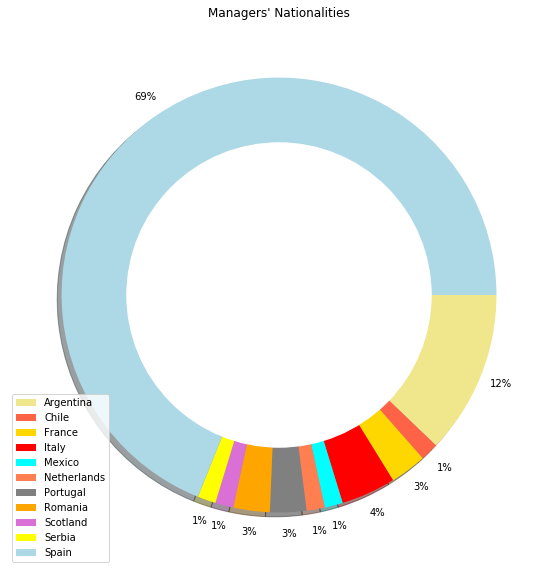

In [8]:
labels = man_country_df.index.values #labels = country names
plt.rcParams["figure.figsize"]=10,10
plt.pie(man_country_df["percentage"], colors = ["khaki", "tomato", "gold", "red", "aqua", "coral", "grey", 
                                                "orange", "orchid", "yellow", "lightblue"], 
     autopct='%1.0f%%',counterclock=False, shadow=True, pctdistance=1.1)
plt.title("Managers' Nationalities")
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.legend(labels, loc = 3)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

As shown in the pie plot, the vast majority of the managers in the spanish championship teams are from Spain (more than 2/3). A small percentage of 12% comes from Argentina, while very small percentages come from other countries.

We want to see whether or not when a team plays in its home wins. 

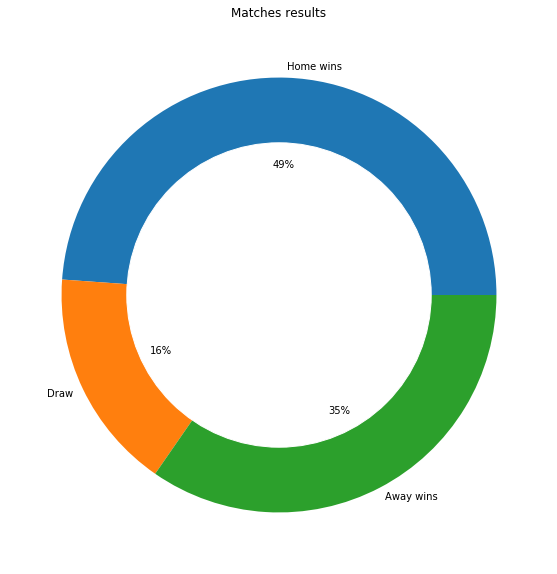

In [9]:
home_wins = laliga_cleaned[laliga_cleaned["result"] == "1"].shape[0] #when home team wins
draw = laliga_cleaned[laliga_cleaned["result"] == "x"].shape[0] #when the result is draw
away_wins = laliga_cleaned[laliga_cleaned["result"] == "2"].shape[0] #when away team wins
x = ["Home wins", "Draw", "Away wins"]
total = laliga_cleaned.shape[0] #total matches
y = [home_wins / total * 100, draw / total * 100, away_wins / total * 100] #get results percentages
plt.rcParams["figure.figsize"]=10,10
plt.pie(y, labels = x, autopct='%1.0f%%', pctdistance=0.6, labeldistance=1.05)
plt.title("Matches results")
my_circle = plt.Circle( (0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

As we can see, almost half of the games are won by the home team. That's a good percentage in trying to predict the winner. Draw is very rare in La Liga matches, as only around 15% of the matches have not a winner. That could mean that teams play always for the win, and they do not compromise with the draw. 

Next, we want to see if there is a difference in the match results when the matches are played in the first or the second round. La Liga has 20 teams, and therefore 38 matches for each team every season. So the first and second round consist of 19 match each. 

In [10]:
first_round = laliga_cleaned[laliga_cleaned["match_week"] <= 19] #first round = 1 - 19 match_week
second_round = laliga_cleaned[laliga_cleaned["match_week"] > 19] #second round = 20 - 38 match_week

home_wins_first_round = first_round[first_round["result"] == "1"].shape[0] #home wins (1st round)
draw_first_round = first_round[first_round["result"] == "x"].shape[0] #draw (1st round)
away_wins_first_round = first_round[first_round["result"] == "2"].shape[0] #away wins (1st round)

home_wins_second_round = second_round[second_round["result"] == "1"].shape[0] #home wins (2nd round)
draw_second_round = second_round[second_round["result"] == "x"].shape[0] #draw (2nd round)
away_wins_second_round = second_round[second_round["result"] == "2"].shape[0] #away wins (2nd round)

wins = (home_wins_first_round * 100 / first_round.shape[0], home_wins_second_round * 100 / second_round.shape[0] )
draw = (draw_first_round * 100 / first_round.shape[0], draw_second_round * 100 / second_round.shape[0])
loses = (away_wins_first_round * 100 / first_round.shape[0], away_wins_second_round * 100 / second_round.shape[0] )

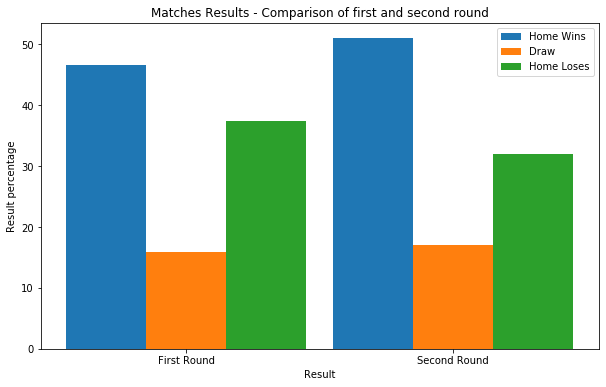

In [11]:
ind = np.arange(2) #xticks
width = 0.3 #columns width      
plt.figure(figsize=(10,6))
plt.bar(ind, wins, width, label='Home Wins')
plt.bar(ind + width, draw, width, label='Draw')
plt.bar(ind + 2 * width, loses, width, label='Home Loses')

plt.ylabel("Result percentage")
plt.xlabel("Result")
plt.xticks(ind + 2 * width / 2, ('First Round', 'Second Round'))
plt.legend(loc='best')
plt.title("Matches Results - Comparison of first and second round")

plt.show()

We can see from the plot above that in the second round teams tend to win more games when they play in home. This is because as the season comes to the end, teams have more clear goals, and the home teams with the fans support can achieve better results. The draw results seem to be the same in both rounds. 

Then, we will try to figure out the percentages of wins for Barcelona and Real Madrid for home and away games. 

In [12]:
barca_home = laliga_cleaned[laliga_cleaned["home_team_name"] == "Barcelona"] #barcelona as home team
barca_home_wins = barca_home[barca_home["result"] == "1"] #barcelona as home team wins
percentage_barca_wins_home = barca_home_wins.shape[0] / barca_home.shape[0] #percentage of home wins
percentage_barca_wins_home

real_home = laliga_cleaned[laliga_cleaned["home_team_name"] == "Real Madrid"] #real as home team
real_home_wins = real_home[real_home["result"] == "1"] #real as home team wins
percentage_real_wins_home = real_home_wins.shape[0] / real_home.shape[0] #percentage of home wins
percentage_real_wins_home

"Real Madrid wins the {}% of the home games while Barcelona wins the {}%".format(round(percentage_real_wins_home *100),round(percentage_barca_wins_home *100))

'Real Madrid wins the 33% of the home games while Barcelona wins the 84%'

In [13]:
barca_away = laliga_cleaned[laliga_cleaned["away_team_name"] == "Barcelona"] #barcelona as away team
barca_away_wins = barca_away[barca_away["result"] == "2"] #barcelona as away team wins
percentage_barca_wins_away = barca_away_wins.shape[0] / barca_away.shape[0] #percentage of away wins
percentage_barca_wins_away

real_away = laliga_cleaned[laliga_cleaned["away_team_name"] == "Real Madrid"] #real as away team
real_away_wins = real_away[real_away["result"] == "2"] #real as away team wins
percentage_real_wins_away = real_away_wins.shape[0] / real_away.shape[0] #percentage of away wins
percentage_real_wins_away

"Real Madrid wins the {}% of the away games while Barcelona wins the {}%".format(round(percentage_real_wins_away *100),round(percentage_barca_wins_away*100))

'Real Madrid wins the 17% of the away games while Barcelona wins the 64%'

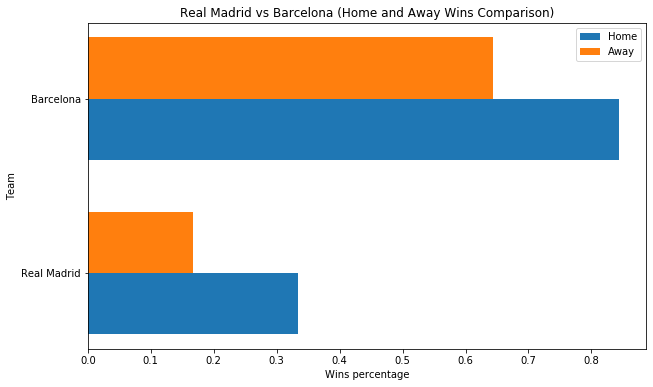

In [14]:
home_res = (percentage_real_wins_home, percentage_barca_wins_home)
away_res = (percentage_real_wins_away, percentage_barca_wins_away)
ind = np.arange(2) #xticks
width = 0.35 #bar width

plt.figure(figsize=(10,6))
plt.barh(ind, home_res, width, label='Home')
plt.barh(ind + width, away_res, width, label='Away')
plt.rcParams["figure.figsize"] = (10,5)

plt.xlabel("Wins percentage")
plt.ylabel("Team")
plt.yticks(ind + width / 2, ('Real Madrid', 'Barcelona'))
plt.legend(loc='best')
plt.title("Real Madrid vs Barcelona (Home and Away Wins Comparison)")
plt.show()

As we can see above Barcelona wins more than 80% of their home games while Real Madrid wins only around 35% of their home games. The percentage for away wins for Real Madrid is even lower (around 15%), while Barcelona's percentage is lower but still good enough (almost than two thirds). 

Next, we will use the Barcelona vs Real Madrid head to head matches to do some analysis. We use the matches where Barcelona is the home team, as well as the matches where Real Madrid is the home team.

In [15]:
#barca real head to head
barca_real = laliga_cleaned[(laliga_cleaned["home_team_name"] == "Barcelona") &
                           (laliga_cleaned["away_team_name"] == "Real Madrid")] #barca home team

real_barca = laliga_cleaned[(laliga_cleaned["home_team_name"] == "Real Madrid") &
                           (laliga_cleaned["away_team_name"] == "Barcelona")] #real home team

In [16]:
real_barca_res = real_barca.groupby(["result"]) #group by result
barca_real_res = barca_real.groupby(["result"]) #group by result

real_wins = real_barca_res.get_group("1").shape[0] #how many matches Real Madrid won when they played in Bernabeu against Barcelona
real_wins_goals = real_barca_res.get_group("1").home_score.mean() #when real wins how many goals in average
real_wins_goals_conc = real_barca_res.get_group("1").away_score.mean() #when real wins how many goals barca scores

real_loses = real_barca_res.get_group("2").shape[0] #how many matches Real Madrid lost when they played in Bernabeu against Barcelona
real_loses_goals = real_barca_res.get_group("2").home_score.mean() #when real loses how many goals in average
real_loses_goals_conc = real_barca_res.get_group("2").away_score.mean() #when real loses how many goals barca scores

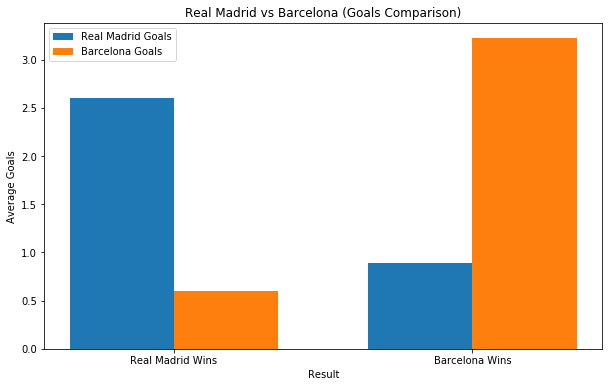

In [17]:
real_g = (real_wins_goals, real_loses_goals) #real madrid goals
real_gc = (real_wins_goals_conc, real_loses_goals_conc) #real madrid goals conceded
ind = np.arange(2) 
width = 0.35       

plt.figure(figsize=(10,6))
plt.bar(ind, real_g, width, label='Real Madrid Goals')
plt.bar(ind + width, real_gc, width, label='Barcelona Goals')
plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("Average Goals")
plt.xlabel("Result")
plt.xticks(ind + width / 2, ('Real Madrid Wins', 'Barcelona Wins'))
plt.legend(loc='best')
plt.title("Real Madrid vs Barcelona (Goals Comparison)")

plt.show()


Observing the plot above, we can see the comparison for the goals scored and conceded for both teams when they win or lose. When Real Madrid wins, they score around 2.5 goals per match, and concede around 0.5 goals. However when Barcelona wins, Real Madrid scores around 1 goal per match, however Barcelona scores more than 3 goals per match. 

One noticeable statistic is that in Real Madrid vs Barcelona matches, we have many goals since when Real Madrid wins in average more than 3 goals are scored, while around 4 goals are scored when Barcelona wins.

Now, we will try to export a plot that will explain the average goals Barcelona scored and conceded through all seasons.

In [18]:
#get by season to show barcelona average goals
barca_matches_home = laliga_cleaned[(laliga_cleaned["home_team_name"] == "Barcelona")] #barcelona as home team

season_groups = barca_matches_home.groupby("season") #group by season to be able to get the mean
barca_goals_scored_home = [] #empty arrays to contain the average goals scored for each season
barca_goals_conceded_home = [] #empty arrays to contain the average goals concede for each season

seasons_names = [] #seasons names
#create the three new arrays with seasons names and average goals scored and conceded when Barcelona played in Camp Nou
for name, group in season_groups:
    seasons_names.append(name)
    barca_goals_scored_home.append(group.home_score.mean())
    barca_goals_conceded_home.append(group.away_score.mean())    

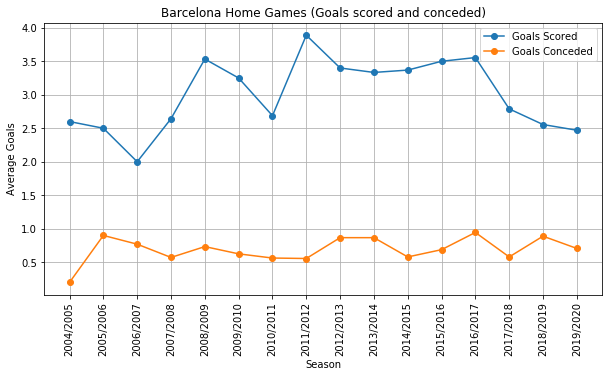

In [19]:
no_of_seasons = range(len(seasons_names)) #numbers from 0 to season number
plt.plot(no_of_seasons, barca_goals_scored_home, no_of_seasons, barca_goals_conceded_home, marker = "o" )
plt.legend(["Goals Scored", "Goals Conceded"])

plt.rcParams["figure.figsize"] = (10,5)
plt.xticks(no_of_seasons, seasons_names, rotation = "vertical")
plt.title("Barcelona Home Games (Goals scored and conceded)")
plt.xlabel("Season")
plt.ylabel("Average Goals")
plt.grid(True)
plt.show()

It would be interesting if we could use the above and see if Barcelona won the championship when they scored many goals and conceded less. So we will need the La Liga champions to be included in the dataset (not included). We create a new dataframe with the championship winners for each season. 

In [20]:
#get La Liga champions https://en.wikipedia.org/wiki/List_of_Spanish_football_champions
season_champion = ["Barcelona", "Barcelona", "Real Madrid", "Real Madrid", "Barcelona", "Barcelona", 
                  "Barcelona", "Real Madrid", "Barcelona", "Atlético Madrid", "Barcelona","Barcelona", "Real Madrid",
                  "Barcelona", "Barcelona", "Real Madrid"]

champions = pd.DataFrame() #new dataframe with seasons and champions
champions["seasons"] = seasons_names
champions["winner"] = season_champion

barca_champions = champions[champions["winner"] == "Barcelona"] #records when Barcelona was champion

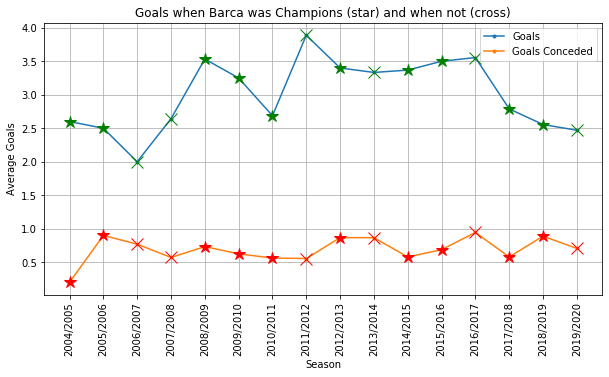

In [21]:
#this function is used to plot different markers for the seasons when Barcelona won the championship and different 
#when other team were champions
def barca_markers(row):
    if row["winner"] != "Barcelona":
        val = "x"
    else:
        val = "*"
    return val

markers = (champions.apply(barca_markers, axis = 1)) #call function to fill with markers

no_of_seasons = range(len(seasons_names)) #numbers from 0 to season number
plt.plot(no_of_seasons, barca_goals_scored_home, no_of_seasons, barca_goals_conceded_home, marker = ".") #line plot

for j, mi in enumerate(markers): #plot the new markers for winning the league or not
    plt.plot(no_of_seasons[j], barca_goals_scored_home[j], marker = markers[j], color = "green", markersize = 12)
    plt.plot(no_of_seasons[j], barca_goals_conceded_home[j], marker = markers[j], color = "red", markersize = 12)
    
plt.rcParams["figure.figsize"] = (10,5)

plt.legend(["Goals", "Goals Conceded"])
plt.title("Goals when Barca was Champions (star) and when not (cross)")
plt.xticks(no_of_seasons, seasons_names, rotation = "vertical")
plt.xlabel("Season")
plt.ylabel("Average Goals")
plt.grid(True)
plt.show()

Observing the plot, one can conclude to some interesting facts. In season 04/05 Barcelona did not scored many goals (around 2.5), but their good defence (around 0.25 goals per match) help them win the championship. Another interesting observation is that the most productive year for Barcelona's home games, the team did not achive to win the La Liga. They concede around 0.75 and scored around 4 goals per match, which is an amazing performance, however they did not win the championship.

Furthermore, one can say that their defence was steady through the years, while the attack had some drops and raises through the last 16 years. 

Now, we will get a single season and see in how many matches Barcelona played and had a clean sheet (no goals conceded). Then we will try to see if there is a correlation between the clean sheet games and whether a specific player played in those games. 

In [22]:
barca_home_matches_12_13 = barca_home[barca_home["season"] == "2012/2013"] #single season barca home games
barca_home_matches_ids_12_13 = barca_home_matches_12_13.match_id #ids

#function for assign true or false whether Barcelona conceded at least one goal when played in home
def f(row):
    if row["away_score"] >= 1:
        val = True
    else:
        val = False
    return val

barca_home_matches_12_13["conc"] = barca_home_matches_12_13.apply(f, axis = 1) #call function

In [23]:
#print(all_files)
match_p = pd.DataFrame() #dataframe with barca home matches players
player_played = [] #if a certain player played in match

for match in barca_home_matches_ids_12_13: #for all matches in season 12/13
    path = "./data/lineups/{}.json".format(match) #path to file
    with open(path) as f:
        a = json.load(f) #read file 
        norm = pd.json_normalize(a, "lineup") #get the nested data (lineup)
        if "Cesc Fàbregas" in norm.player_nickname.values: #if Cesc Fabregas played in the certain game
            player_played.append(True) #if yes assign the boolean value True
        else:
            player_played.append(False) #if not assign the boolean value False

        norm["match_id"] = match #save match_id
        match_p = match_p.append(norm) #append the lineups for Barcelona home games

barca_home_matches_12_13["player"] = player_played #append the new column with played matches by Cesc
barca_home_matches_12_13.head()

,match_id,match_date,kick_off,match_week,season,home_team_id,home_team_name,home_score,away_score,away_team_name,away_team_id,stadium_name,referee_name,result,conc,player
243,70270,2012-09-22,22:00:00.000,5,2012/2013,217,Barcelona,2,0,Granada,1049,Camp Nou,Carlos Del Cerro,1,False,True
244,70281,2013-05-05,21:00:00.000,34,2012/2013,217,Barcelona,4,2,Real Betis,218,Camp Nou,Clos Gómez,1,True,False
245,70308,2012-11-03,18:00:00.000,10,2012/2013,217,Barcelona,3,1,Celta Vigo,209,Camp Nou,David Fernández,1,True,True
248,70271,2013-02-23,22:00:00.000,25,2012/2013,217,Barcelona,2,1,Sevilla,213,Camp Nou,Carlos Velasco Carballo,1,True,False
254,70296,2012-12-16,21:00:00.000,16,2012/2013,217,Barcelona,4,1,Atlético Madrid,212,Camp Nou,Miguel Pérez,1,True,False


Now, we want to see if there is a correalation between Cesc playing and away score is not 0. 

In [24]:
cor = round(np.corrcoef(barca_home_matches_12_13["conc"], barca_home_matches_12_13["player"])[0,1],2) #correalation coefficient
print("Correlation coefficient between Cesc playing and not clean sheets: {}".format(cor))

Correlation coefficient between Cesc playing and not clean sheets: -0.36


The correlation coefficient is not strong, however there is a small evidence that when Cesc does not play, Barcelona's defence is not that good.

Last, we will examine if the two Barca vs Real madrid matches during the season can predict the champion.

In [25]:
#fill new arrays with zeros
size = champions.shape[0] 
real_w = np.zeros(size) 
barca_w = np.zeros(size)
draw= np.zeros(size)

barca_real = laliga_cleaned[(laliga_cleaned["home_team_name"] == "Barcelona") &
                           (laliga_cleaned["away_team_name"] == "Real Madrid")] #Barcelona as home team and Real Madrid as away team
real_barca = laliga_cleaned[(laliga_cleaned["home_team_name"] == "Real Madrid") &
                           (laliga_cleaned["away_team_name"] == "Barcelona")] #Barcelona as away team and Real Madrid as home team

barca_real_seasons = barca_real.groupby("season") #group by season
i = 0 #counter

#for each season count the results
for name, group in barca_real_seasons:
    if (pd.DataFrame(barca_real_seasons.get_group(name)).iloc[0].result == "1"):
        barca_w[i] += 1 #increase Barcelona's wins in this certain year (Barcelona home team)
    elif (pd.DataFrame(barca_real_seasons.get_group(name)).iloc[0].result == "2"):
        real_w[i] += 1 #increase Real Madrid's wins in this certain year (Barcelona home team)
    else:
        draw[i] += 1 #increase draws in this certain year
    i += 1

#do the same for Real Madrid home team
real_barca_seasons = real_barca.groupby("season")
i = 0
for name, group in real_barca_seasons:
    if (pd.DataFrame(real_barca_seasons.get_group(name)).iloc[0].result == "2"):
        barca_w[i] += 1
    elif (pd.DataFrame(real_barca_seasons.get_group(name)).iloc[0].result == "1"):
        real_w[i] += 1
    else:
        draw[i] += 1
    i += 1

In [26]:
champions_head2head = champions.copy() #copy the champions dataframe to add more columns
champions_head2head["barca_w"] = barca_w.astype(int) #add column with number of Barcelona wins in this season to dataframe
champions_head2head["real_w"] = real_w.astype(int) #add column with number of Real wins in this season to dataframe
champions_head2head["draw"] = draw.astype(int)  #add column with number of draws in this season to dataframe

#function to give the seasons that Barcelona were champions
def barca_champion(row):
    if row["winner"] == "Barcelona":
        val = 1
    else:
        val = 0
    return val

champions_head2head["barca_champion"] = champions_head2head.apply(barca_champion, axis = 1) #call function
champions_head2head.head()

,seasons,winner,barca_w,real_w,draw,barca_champion
0,2004/2005,Barcelona,1,0,1,1
1,2005/2006,Barcelona,1,1,0,1
2,2006/2007,Real Madrid,1,1,0,0
3,2007/2008,Real Madrid,2,0,0,0
4,2008/2009,Barcelona,1,1,0,1


Now that we have the data needed to predict the champion we will split the dataset in train and test set, and then fit a logistic regression model and make predicitons. 

In [27]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(champions_head2head, test_size=0.25, random_state = 100 ) #split dataset
train_y = train["barca_champion"] 
train_x = train[["barca_w", "real_w", "draw"]]

test_y = test["barca_champion"]
test_x = test[["barca_w", "real_w", "draw"]]

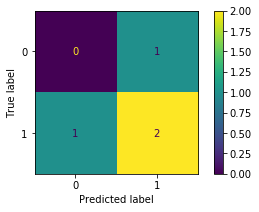

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

clf = LogisticRegression(random_state=0).fit(train_x, train_y) #fit logistic regression model
y_pred = clf.predict(test_x) #predict the test set
#confusion_matrix(test_y, y_pred) #confusion matrix
plt.rcParams["figure.figsize"] = (6,3)
plot_confusion_matrix(clf, test_x, test_y) #plot confusion matrix


Observing the confusion matrix we can see that 2 out of the four times the model made a correct prediction and Barcelona won the championship. One time the model predicted that Barcelona would win the league but they did not, and one time the model predicted that Barcelona would not win the La Liga, but they did.